In [1]:
import xarray as xr 
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import h5py
from scipy.signal import detrend
from sklearn.decomposition import TruncatedSVD
import os
import geopandas as gpd
import regionmask
from scipy.stats import zscore
import itertools
import warnings
warnings.filterwarnings("ignore")
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable
from joblib import Parallel, delayed
import glob
import networkx as nx
import nclcmaps
from tqdm import tqdm
###################################################
import re 
def tryint(s):
    try:
        return int(s)
    except ValueError:
        return s
    
def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)


    # ----------------------------------------------------
def convert_to_non_nan_2d_array(ds):
# Check for valid time dimension
    if 'time' in ds.dims:
        time_len = len(ds.time.values)
    elif 'year' in ds.dims:  # Fallback to 'year' if 'time' is not available
        time_len = len(ds.year.values)
    else:
        raise ValueError("No valid time dimension found.")
    # Extract the dimensions for lat and lon
    lat_len = ds.sizes['lat']
    lon_len = ds.sizes['lon']
    
    # Reshape the data into a 2D array (time x space)
    scpdsi_2d = ds.values.reshape(time_len, lat_len * lon_len)
    
    # Identify columns that are not entirely NaN
    non_nan_mask = ~np.isnan(scpdsi_2d).any(axis=0)
    non_nan_mask[16719] =0  # these two numbers are where event series has all nan and they have to be removed manuallly
    non_nan_mask[137448] =0
    # Apply the mask to filter out columns with all NaN values
    scpdsi_non_nan = scpdsi_2d[:, non_nan_mask]
    
    return scpdsi_non_nan, non_nan_mask


In [2]:
filepath = "data/scPDSI.cru_ts4.06early1.1901.2021.cal_1950_21.bams.2022.GLOBAL.IGBP.WHC.1901.2021.nc"
scpdsi_nc = xr.open_dataset(filepath).sel(time = slice("1901","2021")).scpdsi.rename({"latitude":"lat","longitude":"lon"})
ds,mask = convert_to_non_nan_2d_array(scpdsi_nc)

In [3]:
A = np.load("Aij_full.npy")
dis = np.load("distance.npy").astype(np.int64)
deg = np.load("deg_full.npy")

# plottting Prerequistes 


# plotting degree spatial and Temporal 

In [4]:
lat = scpdsi_nc.lat.values
lon = scpdsi_nc.lon.values
coords = np.array(list(itertools.product(lon,lat)))
coords_valid = coords[mask]
deg = np.load("deg_full.npy")
deg_arr = np.ones((len(lat)*len(lon)))*np.nan
deg_arr[mask] = deg                                             
deg_arr = deg_arr.reshape(len(lat),len(lon))
deg_xr= xr.DataArray(deg_arr, dims=["lat", "lon"],
                       coords={"lat": lat,
                               "lon": lon})


cmap= nclcmaps.cmap('perc2_9lev')

In [5]:
lat_radians = np.deg2rad(deg_xr['lat'])  

cos_lat = np.cos(lat_radians)

corrected_deg = deg_xr * cos_lat

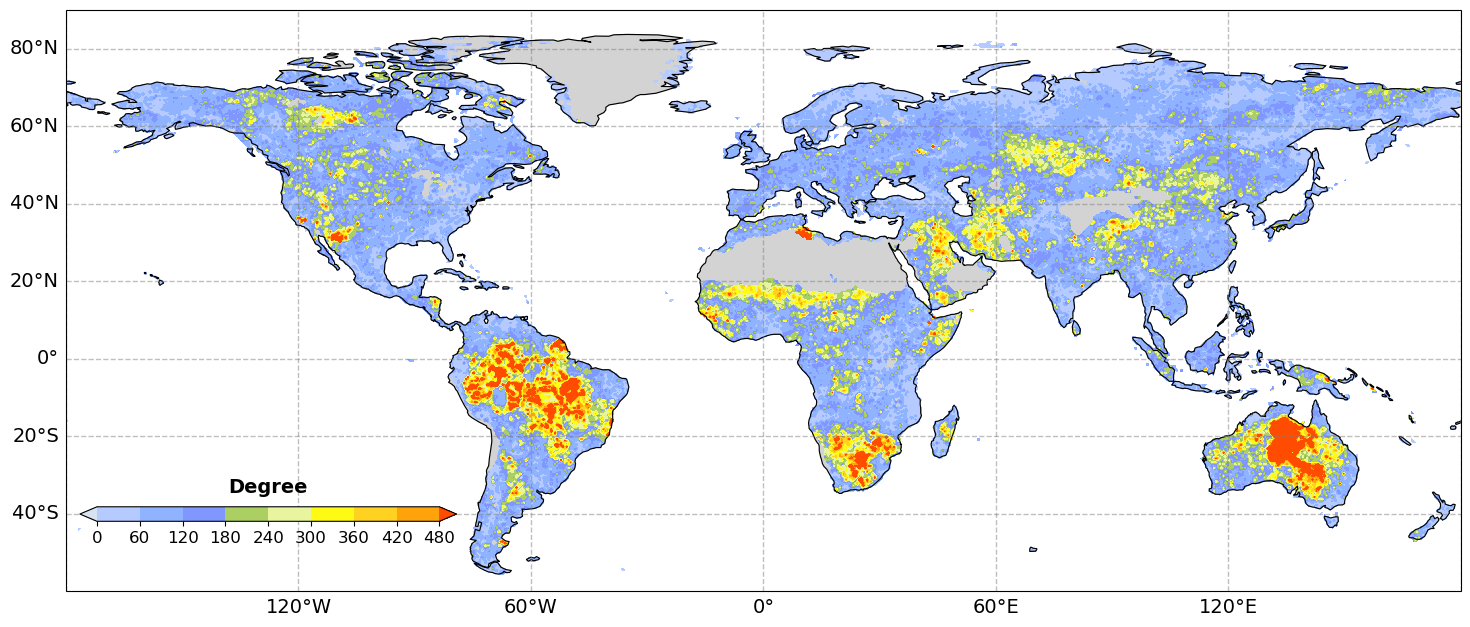

In [6]:
from matplotlib import colorbar
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
cmap= nclcmaps.cmap('perc2_9lev')
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Setting labels with more customization
ax.set_xlabel('Longitude', fontsize=14, fontweight='bold', color='darkblue')
ax.set_ylabel('Latitude', fontsize=14, fontweight='bold', color='darkblue')

# Enhanced land features
land_feature = cfeature.LAND.with_scale('110m')
ax.add_feature(land_feature, facecolor='lightgray')

ax.coastlines(resolution='110m', color='black', linewidth=0.85) # Adjust resolution and style

gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_extent([-180,180,-60,90])
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 14, 'color': 'black' }
gl.xlabel_style = {'size': 14,'color': 'black' }
plot = corrected_deg.plot.contourf(ax=ax, cmap=cmap, add_colorbar=False, 
                                   transform=ccrs.PlateCarree(), robust=True, extend='both',levels =9)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cb_ax = inset_axes(ax, width="27%", height="2.5%", loc='lower left', 
                   bbox_to_anchor=(0.01, 0.12, 1, 1), 
                   bbox_transform=ax.transAxes, 
                   borderpad=0)

cbar = plt.colorbar(plot, cax=cb_ax, orientation='horizontal',drawedges = False)
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Degree", size=14, color='k', fontweight='bold',labelpad =10)
cbar.ax.xaxis.set_label_position('top')
plt.savefig("Degree_corrected.png",dpi=600)
plt.show()

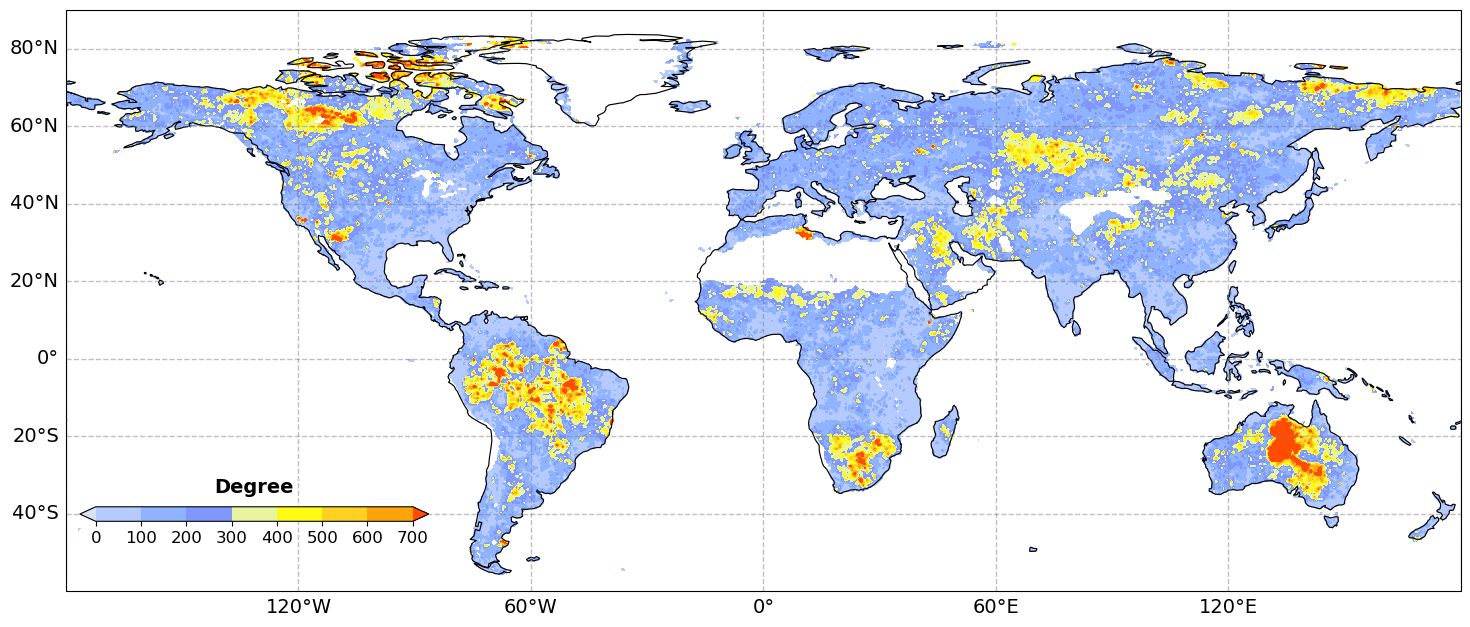

In [10]:
from matplotlib import colorbar
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
cmap= nclcmaps.cmap('perc2_9lev')
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Setting labels with more customization
ax.set_xlabel('Longitude', fontsize=14, fontweight='bold', color='darkblue') # Try changing color
ax.set_ylabel('Latitude', fontsize=14, fontweight='bold', color='darkblue') # Try changing color

# Enhanced land features
land_feature = cfeature.LAND.with_scale('50m')
ax.add_feature(land_feature, facecolor='white') # Changed facecolor for a subtle appearance

ax.coastlines(resolution='110m', color='black', linewidth=0.85) # Adjust resolution and style
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') #.xlabels_top = False # Disable top labels
ax.set_extent([-180,180,-60,90])
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 14, 'color': 'black' }
gl.xlabel_style = {'size': 14,'color': 'black' }


# Plotting with contourf
plot = deg_xr.plot.contourf(ax=ax, cmap=cmap, add_colorbar=False, transform=ccrs.PlateCarree(), robust=True, extend='both') # Changed cmap for a different look

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cb_ax = inset_axes(ax, width="25%", height="2.5%", loc='lower left', 
                   bbox_to_anchor=(0.01, 0.12, 1, 1), 
                   bbox_transform=ax.transAxes, 
                   borderpad=0)

# Create the color bar
cbar = plt.colorbar(plot, cax=cb_ax, orientation='horizontal',drawedges = False)
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Degree", size=14, color='k', fontweight='bold',labelpad =10)

cbar.ax.xaxis.set_label_position('top')


plt.show()


In [11]:
Deg_full = np.load("deg_all_periods.npy").T
Deg_full.shape
avg_deg = np.mean(Deg_full,axis=1)

In [12]:
msd_all = np.load("MSD_all_period.npy").T
msd_all[np.isnan(msd_all)] =  0

In [13]:
import numpy as np
import pymannkendall as mk
from tqdm import tqdm
def mann_kendall_trend(arr, axis=0):
    trends = []
    slopes = []
    
    if axis == 1:
        for row in arr:
            result = mk.original_test(row)
            trends.append(result.trend)
            slopes.append(result.slope)
    elif axis == 0:
        for i in tqdm(range(arr.shape[1])):
            result = mk.original_test(arr[:, i])
            p = result.p
            if p<0.05:   
                trends.append(result.trend)
                slopes.append(result.slope)
            else:
                trends.append(np.nan)
                slopes.append(np.nan)
    
    return trends, slopes

# Calculate trends and slopes for each row
row_trends, row_slopes = mann_kendall_trend(msd_all, axis=0)


100%|██████████| 59721/59721 [01:37<00:00, 614.26it/s]


# slopes for degree


In [10]:
lat = scpdsi_nc.lat.values
lon = scpdsi_nc.lon.values
slopes_deg = np.load("/home/mircore/Desktop/hemant/Drought_analysis_march18_Hemant/slope_deg.npy")
slope_xr_deg = xr.DataArray(slopes_deg, dims=["lat", "lon"],
                       coords={"lat": lat,
                               "lon": lon})

# ------------ 
slope_link_length = np.load("/home/mircore/Desktop/hemant/Drought_analysis_march18_Hemant/slope_link_length.npy")
slope_link_length_xr = xr.DataArray(slope_link_length, dims=["lat", "lon"],
                       coords={"lat": lat,
                               "lon": lon})

# trend plot

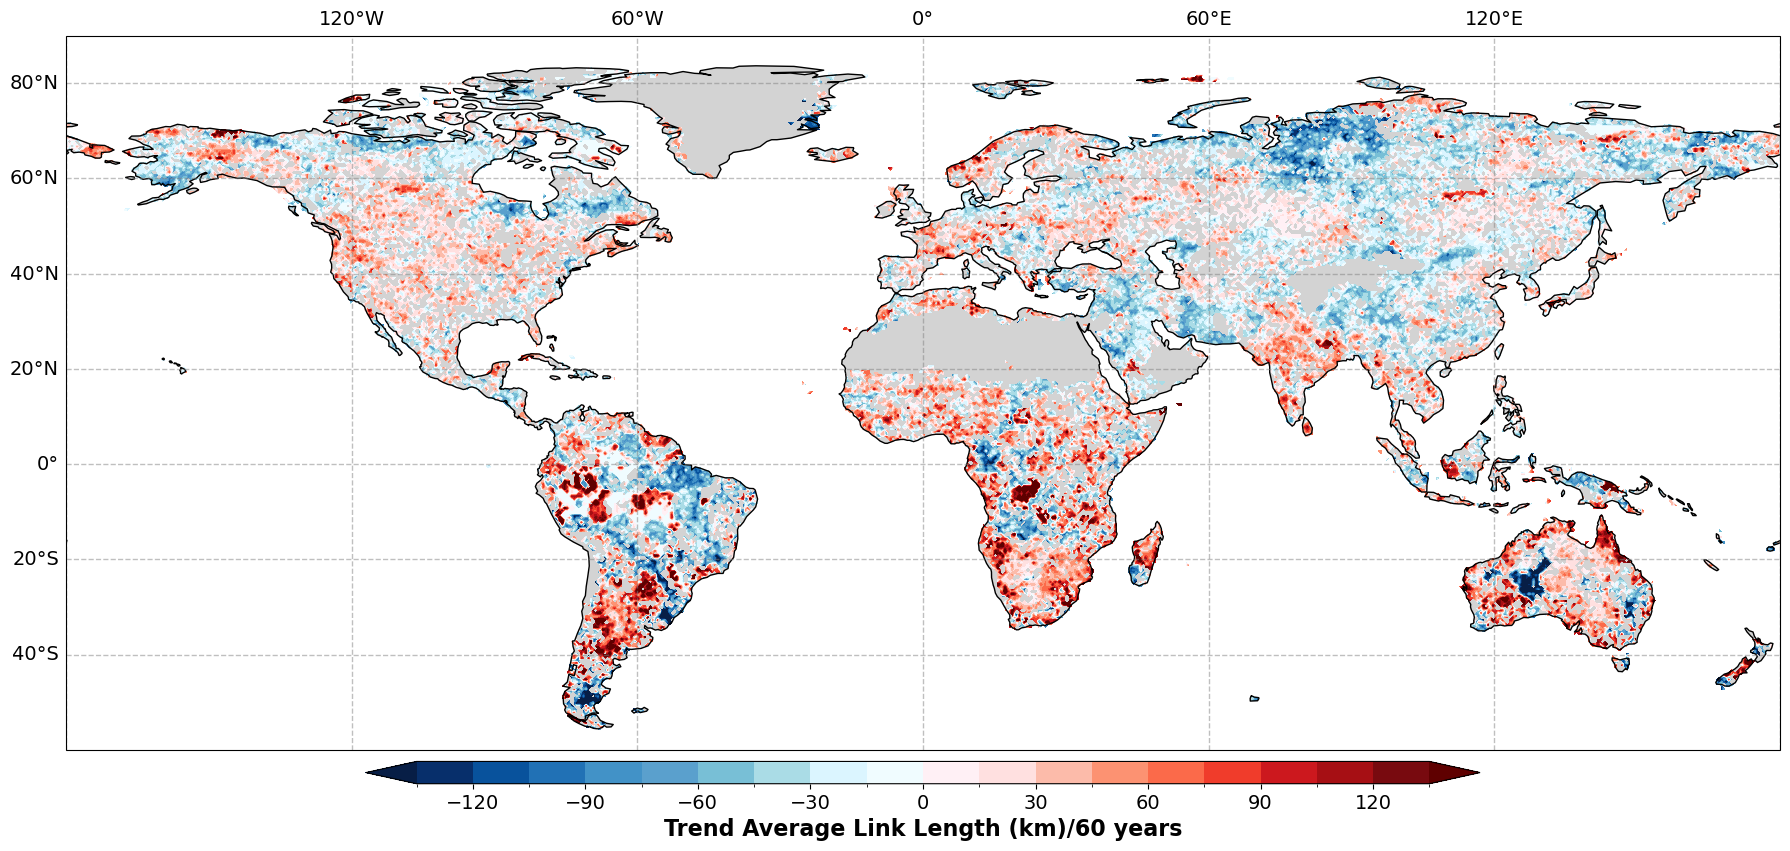

In [34]:
from matplotlib import colorbar
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
cmap= nclcmaps.cmap('temp_19lev')
# Enhanced figure settings
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Setting labels with more customization
ax.set_xlabel('Longitude', fontsize=14, fontweight='bold', color='darkblue') # Try changing color
ax.set_ylabel('Latitude', fontsize=14, fontweight='bold', color='darkblue') # Try changing color

# Enhanced land features
land_feature = cfeature.LAND.with_scale('110m')
ax.add_feature(land_feature, facecolor='lightgray') # Changed facecolor for a subtle appearance


# Coastlines with more control
ax.coastlines(resolution='110m', color='black', linewidth=1) # Adjust resolution and style

# Enhanced gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') #.xlabels_top = False # Disable top labels
ax.set_extent([-180,180,-60,90])
gl.xlabels_top = True
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 14, 'color': 'black' }
gl.xlabel_style = {'size': 14,'color': 'black' }


# Plotting with contourf
plot = slope_link_length_xr.plot.contourf(ax=ax, cmap=cmap, add_colorbar=False, transform=ccrs.PlateCarree(), robust=True, extend='both',levels =19)
cbar = plt.colorbar(plot, orientation='horizontal', pad=0.01, aspect=50,shrink =0.65) # Changed to horizontal
cbar.ax.tick_params(labelsize=14) # Adjust tick size
cbar.set_label("Trend Average Link Length (km)/60 years", size=16, color='k', fontweight='bold') # Adjust label settings
plt.tight_layout()
plt.show()


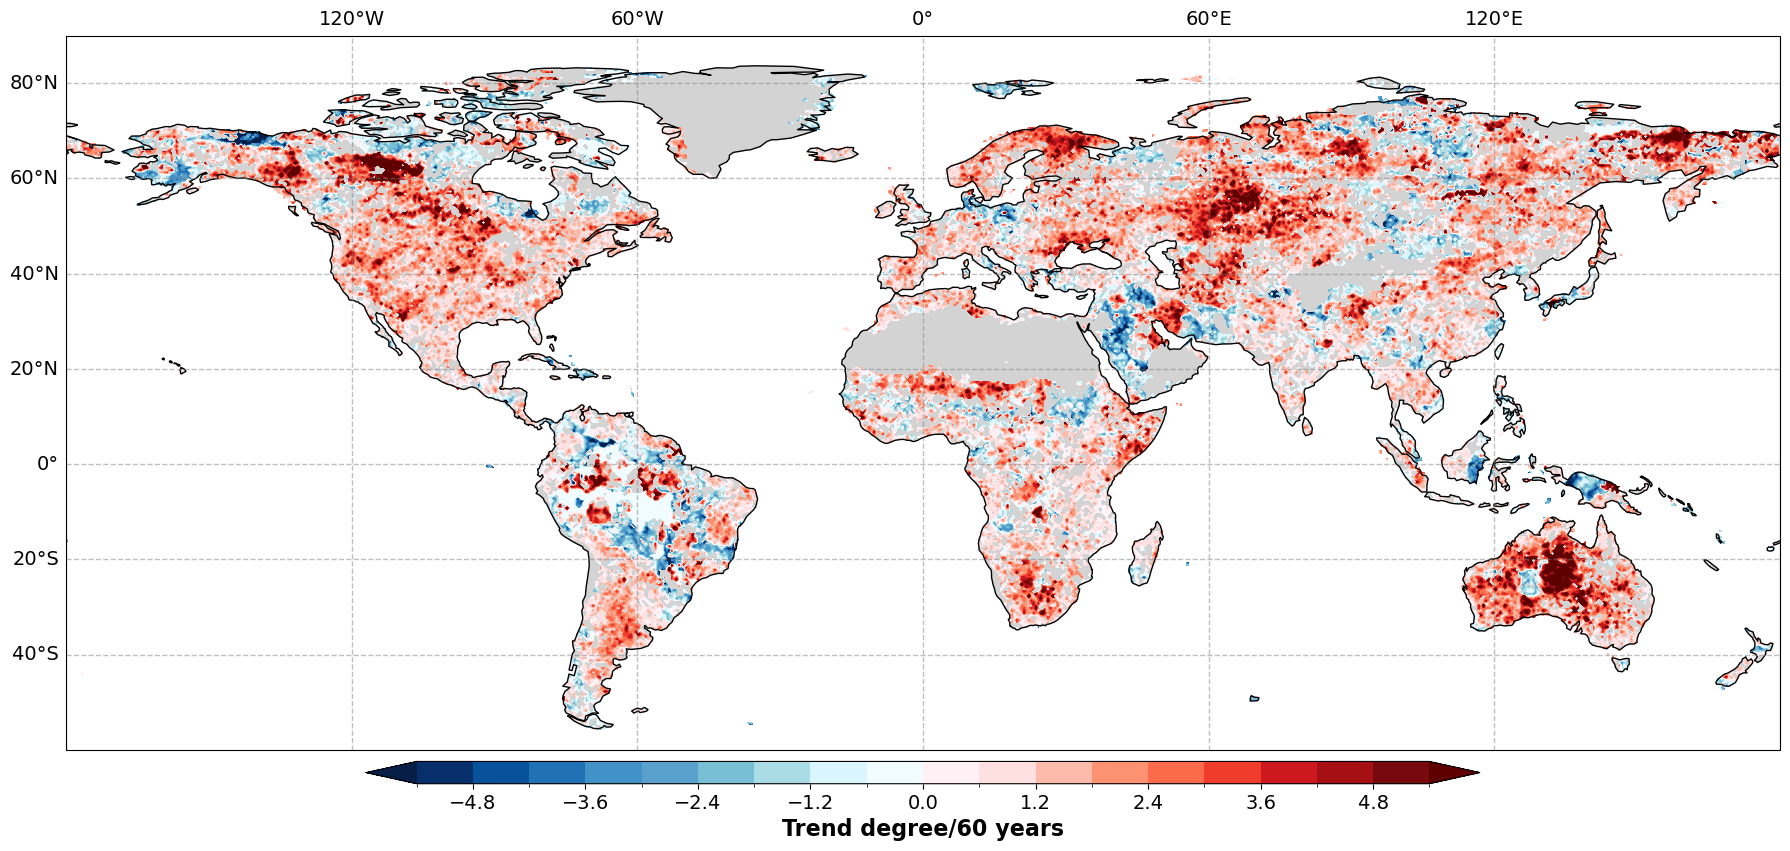

In [35]:
from matplotlib import colorbar
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
cmap= nclcmaps.cmap('temp_19lev')
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Setting labels with more customization
ax.set_xlabel('Longitude', fontsize=14, fontweight='bold', color='darkblue') # Try changing color
ax.set_ylabel('Latitude', fontsize=14, fontweight='bold', color='darkblue') # Try changing color

# Enhanced land features
land_feature = cfeature.LAND.with_scale('110m')
ax.add_feature(land_feature, facecolor='lightgray') # Changed facecolor for a subtle appearance

ax.coastlines(resolution='110m', color='black', linewidth=1) # Adjust resolution and style
# Enhanced gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') #.xlabels_top = False # Disable top labels
ax.set_extent([-180,180,-60,90])
gl.xlabels_top = True
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 14, 'color': 'black' }
gl.xlabel_style = {'size': 14,'color': 'black' }
# Plotting with contourf
plot = slope_xr_deg.plot.contourf(ax=ax, cmap=cmap, add_colorbar=False, transform=ccrs.PlateCarree(), robust=True, extend='both',levels =19)
cbar = plt.colorbar(plot, orientation='horizontal', pad=0.01, aspect=50,shrink =0.65) # Changed to horizontal
cbar.ax.tick_params(labelsize=14) # Adjust tick size
cbar.set_label("Trend degree/60 years", size=16, color='k', fontweight='bold') # Adjust label settings
plt.tight_layout()
plt.savefig("Trend_degree.png",dpi=600)
plt.show()


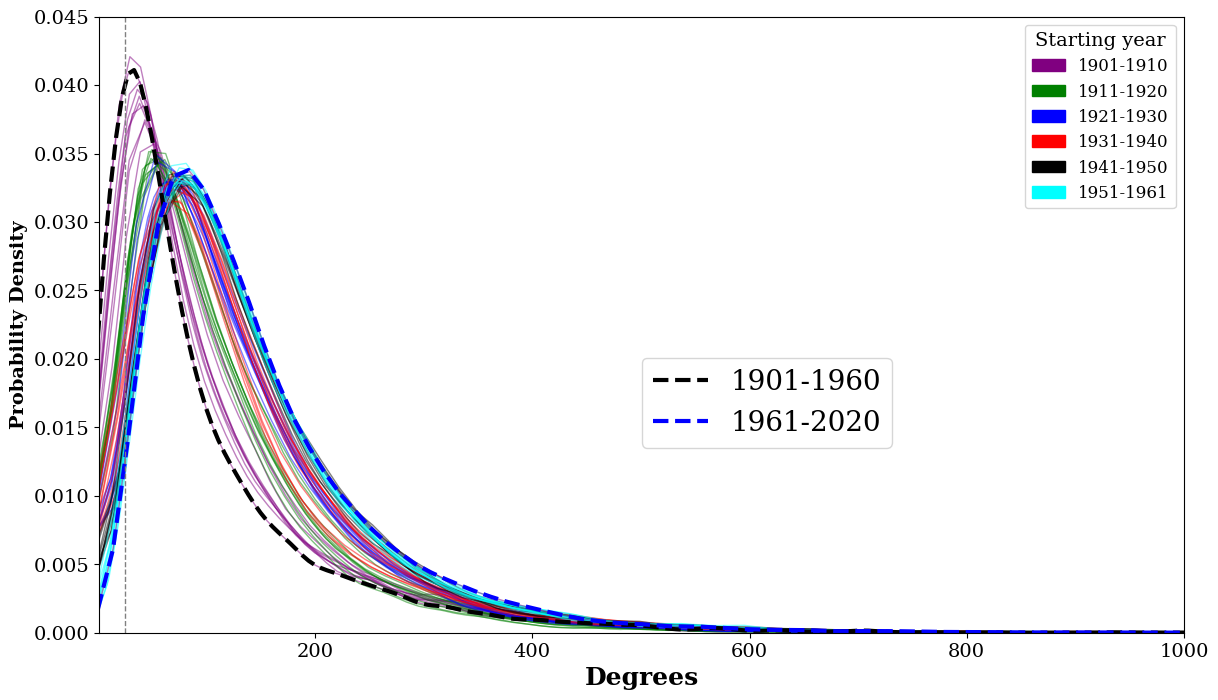

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from collections  import Counter


fig, ax1 = plt.subplots(figsize=(14, 8))


colors =['purple', 'green', 'blue', 'red', 'black', 'cyan']
period = [
    '1901-1910',
    '1911-1920',
    '1921-1930',
    '1931-1940',
    '1941-1950',
    '1951-1961']
total_deg = Deg_full.shape[1]
for i in range(61):
    group_color = colors[i // 10 % len(colors)]
    sns.histplot(data=Deg_full[i], stat='probability', bins='auto', common_norm=True,
                  element='bars', fill=True, shrink=0, kde=True,color=group_color,
                line_kws={ 'lw': 1, 'ls': '-','alpha':0.50})

sns.histplot(data=Deg_full[0], stat='probability', bins='auto', common_norm=True,
            element='bars', fill=True, shrink=0, kde=True,color='k',
             line_kws={'color': 'k', 'lw': 3, 'ls': '--','alpha':1,'label':'1901-1960'})

sns.histplot(data=Deg_full[60], stat='probability', bins='auto', common_norm=True,
            element='bars', fill=True, shrink=0, kde=True,color='b',
             line_kws={'color': 'b', 'lw': 3, 'ls': '--','alpha':1,'label':'1961-2020'})




legend1 = plt.legend(loc=(0.5,0.3),ncol=1,fontsize = 20)
plt.gca().add_artist(legend1)

legend_handles = [mpatches.Patch(color=colors[i], label=period[i]) for i in range(len(period))]
legend = plt.legend(handles=legend_handles, title="Starting year", title_fontsize=14, fontsize=12, loc='upper right')
legend.get_title().set_fontsize(14)
# plt.xscale('log')
plt.axvline(x = 25, color = 'gray', linestyle = '--',linewidth=1)
# ax1.grid(color='black', linestyle='--',alpha =0.5)
ax1.set_xlabel('Degrees',fontsize = 18,weight = 'bold')
ax1.set_ylabel('Probability Density',fontsize = 14,weight = 'bold')
plt.xlim(1, 1000)
plt.ylim(0,0.045)
# plt.rcParams.update({'font.size': 14, 'font.family': 'serif'})
# plt.savefig("/home/mircore/Desktop/hemant/Udit_Global_Droughts/Figures/FIGURE1/degree_evolution.png",dpi = 450)
plt.show()


# lcc spatial

In [5]:
lat = scpdsi_nc.lat.values
lon = scpdsi_nc.lon.values
coords = np.array(list(itertools.product(lon,lat)))
coords_valid = coords[mask]
lcc = np.load("Lcc_1901_2021.npy")
lcc_arr = np.ones((len(lat)*len(lon)))*np.nan
lcc_arr[mask] = lcc
lcc_arr = lcc_arr.reshape(len(lat),len(lon))
lcc_xr= xr.DataArray(lcc_arr, dims=["lat", "lon"],
                       coords={"lat": lat,
                               "lon": lon})




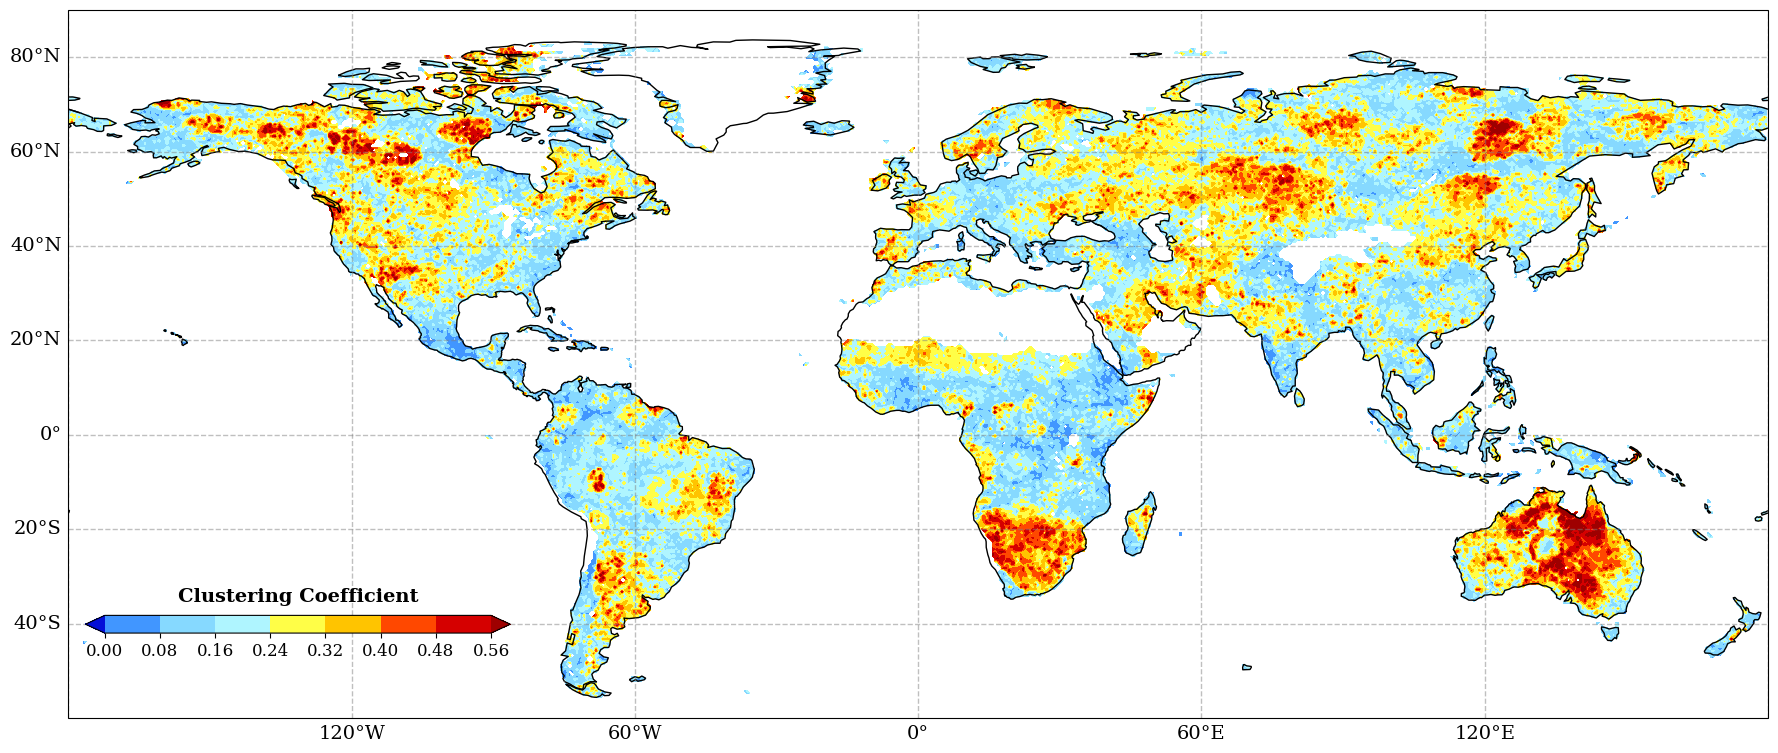

In [57]:
from matplotlib import colorbar
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
cmap= nclcmaps.cmap('GMT_panoply')
# Enhanced figure settings
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Setting labels with more customization
ax.set_xlabel('Longitude', fontsize=14, fontweight='bold', color='darkblue') # Try changing color
ax.set_ylabel('Latitude', fontsize=14, fontweight='bold', color='darkblue') # Try changing color

# Enhanced land features
land_feature = cfeature.LAND.with_scale('50m')
ax.add_feature(land_feature, facecolor='white') # Changed facecolor for a subtle appearance

# Coastlines with more control
ax.coastlines(resolution='110m', color='black', linewidth=1) # Adjust resolution and style

# Enhanced gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') #.xlabels_top = False # Disable top labels
ax.set_extent([-180,180,-60,90])
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 14, 'color': 'black' }
gl.xlabel_style = {'size': 14,'color': 'black' }


# Plotting with contourf
plot = lcc_xr.plot.contourf(ax=ax, cmap=cmap, add_colorbar=False, transform=ccrs.PlateCarree(), robust=True, extend='both') # Changed cmap for a different look



from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cb_ax = inset_axes(ax, width="25%", height="2.5%", loc='lower left', 
                   bbox_to_anchor=(0.01, 0.12, 1, 1), 
                   bbox_transform=ax.transAxes, 
                   borderpad=0)

# Create the color bar
cbar = plt.colorbar(plot, cax=cb_ax, orientation='horizontal',drawedges = False)
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Clustering Coefficient", size=14, color='k', fontweight='bold',labelpad =10)

cbar.ax.xaxis.set_label_position('top')
plt.tight_layout()

plt.show()


# modularity in last window 

In [ ]:
Adj = np.load("/home/mircore/Desktop/hemant/Drought_analysis_march18_Hemant/Adjacency_matrix/A_1961.npy")
import igraph as ig
import louvain


g = graph = ig.Graph.Adjacency(Adj)

# Use the Louvain algorithm to detect communities
partition2 = louvain.find_partition(g, louvain.ModularityVertexPartition)

# Accessing the partition results
print("Modularity:", partition2.modularity)
print("Number of communities:", len(partition2))


In [78]:
lat = scpdsi_nc.lat.values
lon = scpdsi_nc.lon.values
coords = np.array(list(itertools.product(lon,lat)))
coords_valid = coords[mask]

com_arr = np.ones((len(lat)*len(lon)))*np.nan
com_arr[mask] = dis_2d
com_arr = com_arr.reshape(len(lat),len(lon))
msd_xr= xr.DataArray(com_arr, dims=["lat", "lon"],
                       coords={"lat": lat,
                               "lon": lon})




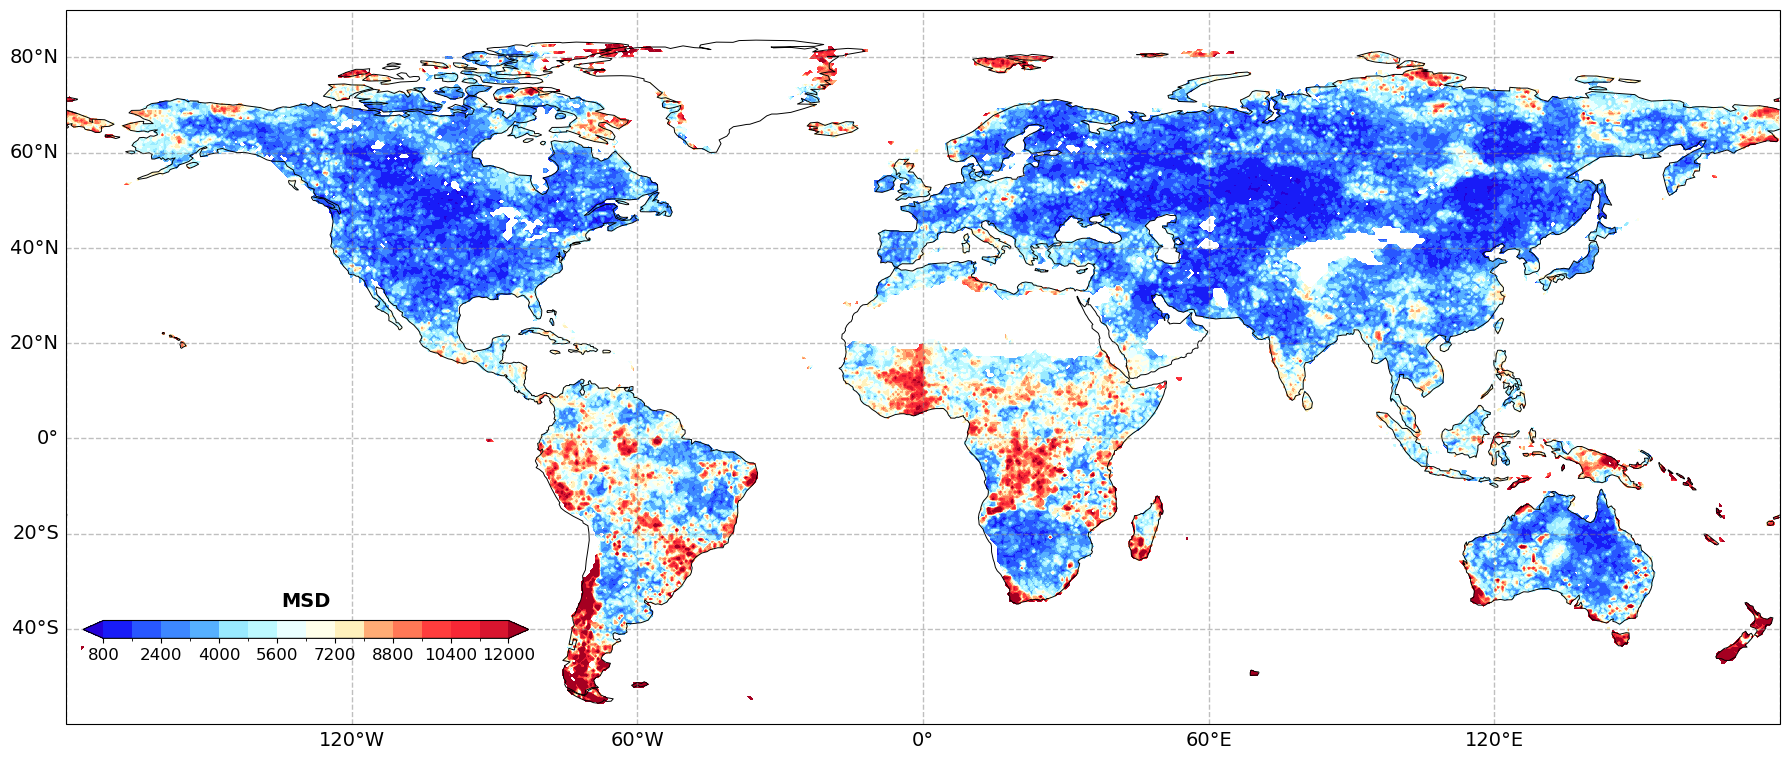

In [83]:
cmap= nclcmaps.cmap('BlueDarkRed18')



fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_xlabel('Longitude', fontsize=14, fontweight='bold', color='darkblue') # Try changing color
ax.set_ylabel('Latitude', fontsize=14, fontweight='bold', color='darkblue') # Try changing color

# Enhanced land features
land_feature = cfeature.LAND.with_scale('50m')
ax.add_feature(land_feature, facecolor='white') # Changed facecolor for a subtle appearance



# Coastlines with more control
ax.coastlines(resolution='110m', color='black', linewidth=0.7) # Adjust resolution and style

# Enhanced gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
ax.set_extent([-180,180,-60,90])
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 14, 'color': 'black' }
gl.xlabel_style = {'size': 14,'color': 'black' }


# Plotting with contourf
plot = msd_xr.plot.contourf(ax=ax, cmap=cmap, add_colorbar=False, transform=ccrs.PlateCarree(), levels = 18,robust=True, extend='both') 



from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cb_ax = inset_axes(ax, width="26%", height="2.5%", loc='lower left', 
                   bbox_to_anchor=(0.01, 0.12, 1, 1), 
                   bbox_transform=ax.transAxes, 
                   borderpad=0)

# Create the color bar
cbar = plt.colorbar(plot, cax=cb_ax, orientation='horizontal',drawedges = False)
cbar.ax.tick_params(labelsize=12)
cbar.set_label("MSD", size=14, color='k', fontweight='bold',labelpad =10)

cbar.ax.xaxis.set_label_position('top')



plt.tight_layout()


plt.show()
